In [8]:
%load_ext autoreload

In [9]:
%autoreload 2
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import scipy
from scipy.signal import stft
import sys
import time
from tqdm.auto import tqdm

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

sys.path.append("../../../../repos/neur_stab/nsta")
from core import estimate_stability_using_particle

# Load Neural Data 

In [10]:
session = 'Mary-Anesthesia-20160912-02'

In [11]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [12]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [13]:
spike_times = spike_times[0]

# Get RNN Going

In [34]:
# # RANDOM CHAOTIC MODEL
# N = len(electrode_info['area'])
# N = 50
# g = 1.7
# tau = 100 # ms
# dt = 0.001 # s
# # dt = 0.015 # s
# W = np.random.randn(N, N)*g/np.sqrt(N)
# b = np.zeros(N)

# TRAINED PERCEPTUAL DISCRIMINATION TASK WEIGHTS
N = 128
tau = 100 # ms
dt = 0.015 # s
W = pd.read_pickle('perceptual_task_weights/W_trained_numpy.pickle')
# g = 1.7
# W += np.random.randn(N, N)*g/np.sqrt(N)
b = pd.read_pickle('perceptual_task_weights/b_trained_numpy.pickle')

wake_mins = 15
induction_mins = 15
during_mins = 45
post_mins = 15

# wake_mins = 1
# induction_mins = 1
# during_mins = 1
# post_mins = 1

# wake_scale = 0.5
# during_scale = 1
# post_scale = 0.5

wake_scale = 1.0
during_scale = 1.0
post_scale = 1.0

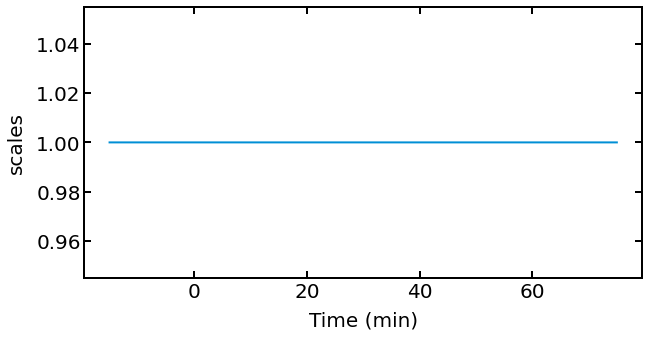

In [35]:
scales = np.hstack([[wake_scale]*int(wake_mins*60*int(1/dt)), np.linspace(wake_scale, during_scale, int(induction_mins*60*int(1/dt))), [during_scale]*int(during_mins*60*int(1/dt)), np.linspace(during_scale, post_scale, int(post_mins*60*int(1/dt)))])

T = int((wake_mins + induction_mins + during_mins + post_mins)*60*int(1/dt))

plt.plot(np.arange(scales.shape[0])/(int(1/dt)*60) - wake_mins, scales)
plt.xlabel("Time (min)")
plt.ylabel('scales')
plt.show()

In [36]:
x = np.zeros((T, N))
Js = np.zeros((T-1, N, N))
x[0] = np.random.randn(N)
W_eff = W.copy()
neg_inds = W < 0
I = np.eye(N)
alpha = (int(dt*1000)/tau)
for t in tqdm(range(1, T)):
    W_eff[neg_inds] = W[neg_inds]*scales[t]
    x[t] = x[t - 1] + alpha*(-x[t - 1] + W_eff @ np.tanh(x[t - 1]) + b + np.sqrt(2/alpha)*np.random.randn()*0.01)
    Js[t - 1] = -I + dt*np.multiply(W_eff, 1 - np.tanh(x[t - 1])**2)

  0%|          | 0/356399 [00:00<?, ?it/s]

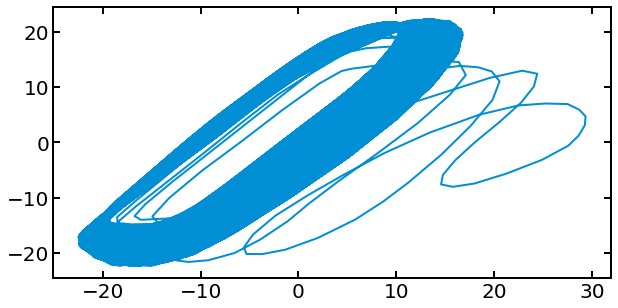

In [22]:
proj1 = x @ np.random.randn(N)
proj2 = x @ np.random.randn(N)
plt.plot(proj1, proj2)
plt.show()

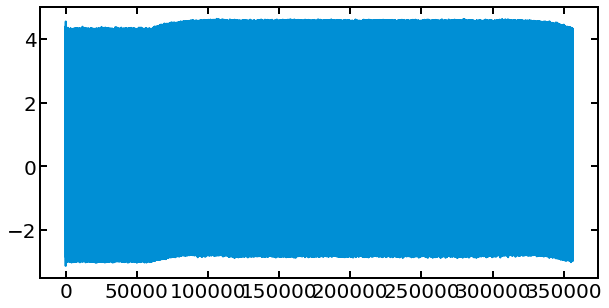

In [23]:
plt.plot(x[:, 1])
plt.show()

In [24]:
window = 2 # s
p = 50
window_ms = int(window/dt)
num_windows = int(np.ceil(Js.shape[0]/window_ms))
lams = np.zeros((num_windows, p))
for i in tqdm(range(num_windows)):
    window_Js = Js[i*window_ms:np.min([(i+1)*window_ms, Js.shape[0]])]
    lams[i] = estimate_stability_using_particle(window_Js, p)

  0%|          | 0/2680 [00:00<?, ?it/s]

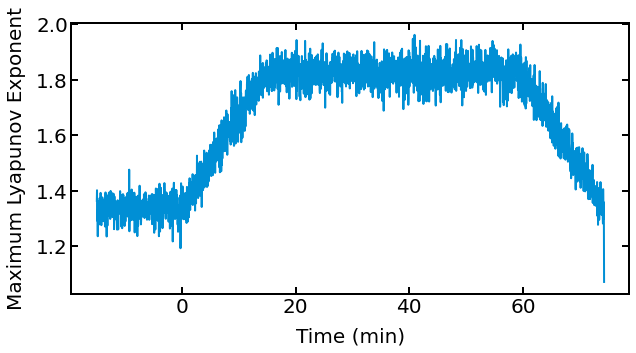

In [25]:
plt.plot(np.arange(lams.shape[0])*window/60 - wake_mins, (lams/dt).mean(axis=1))
plt.xlabel('Time (min)')
plt.ylabel('Maximum Lyapunov Exponent')
plt.show()

In [26]:
eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [27]:
indices = np.random.choice(np.arange(lfp.shape[1]), size=(N,))
neural_data = lfp[int(session_info['drugStart'][0]/0.001) - 15*60*1000:int(session_info['drugEnd'][1]/0.001) + 15*60*1000, indices]

In [38]:
neural_data = lfp[int(session_info['drugStart'][0]/0.001) - 15*60*1000:int(session_info['drugEnd'][1]/0.001) + 15*60*1000]

In [28]:
neural_data = neural_data[np.arange(0, neural_data.shape[0], int(dt*1000))]

In [29]:
neural_data = neural_data[:x.shape[0]]

In [30]:
window = 2 # s
window = int(window/dt)
num_windows = int(neural_data.shape[0]/window)
disparity = np.zeros(num_windows)
random_disparity = np.zeros(num_windows)
for window_ind in tqdm(range(num_windows)):
    simulated = x[window_ind*window:(window_ind + 1)*window]
    neural = neural_data[window_ind*window:(window_ind + 1)*window]
    mtx1, mtx2, disparity[window_ind] = scipy.spatial.procrustes(simulated, neural)
    _, _, random_disparity[window_ind] = scipy.spatial.procrustes(neural, np.random.randn(*simulated.shape))

  0%|          | 0/2679 [00:00<?, ?it/s]

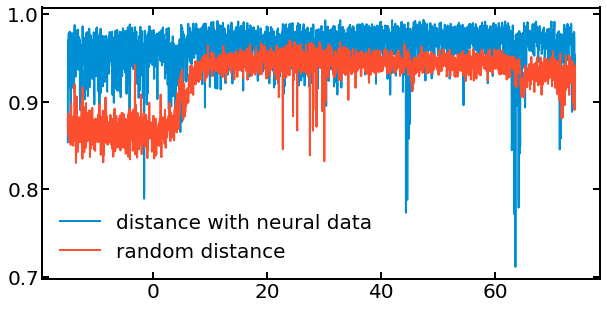

In [31]:
plt.plot(np.arange(disparity.shape[0])*window*dt/60 - 15, disparity, label='distance with neural data')
plt.plot(np.arange(disparity.shape[0])*window*dt/60 - 15, random_disparity, label='random distance')
plt.legend()
plt.show()

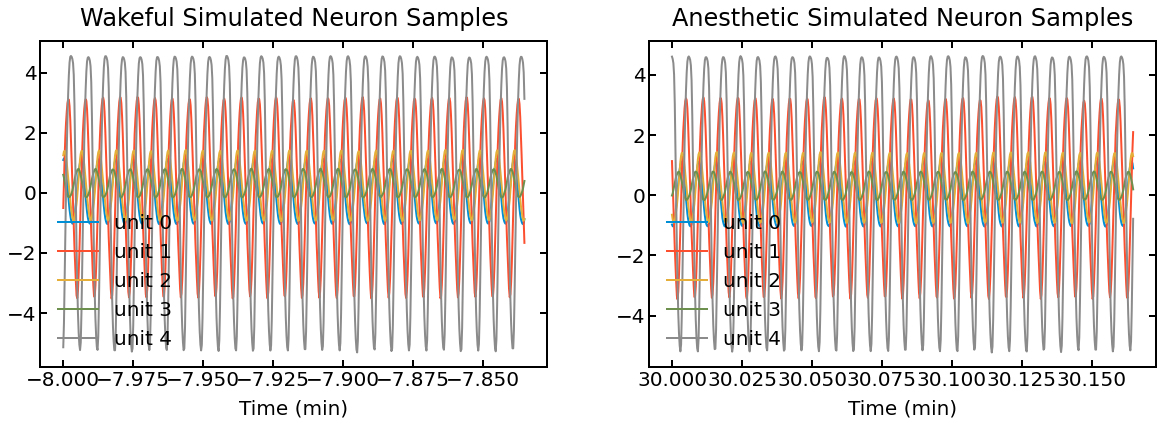

In [37]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
start_time = 7 # minutes
duration = 10 # s
for i in range(5):
    time_series = x[start_time*60*int(1/dt):start_time*60*int(1/dt) + duration*int(1/dt), i]
    plt.plot(start_time + np.arange(time_series.shape[0])*dt/60 - 15, time_series - time_series.mean() + i*0.1, label=f'unit {i}')
plt.legend()
plt.xlabel('Time (min)')
plt.title("Wakeful Simulated Neuron Samples")
plt.subplot(1, 2, 2)
start_time = 45 # minutes
duration = 10 # s
for i in range(5):
    time_series = x[start_time*60*int(1/dt):start_time*60*int(1/dt) + duration*int(1/dt), i]
    plt.plot(start_time + np.arange(time_series.shape[0])*dt/60 - 15, time_series - time_series.mean() + i*0.1, label=f'unit {i}')
plt.legend()
plt.xlabel('Time (min)')
plt.title("Anesthetic Simulated Neuron Samples")
plt.show()

# Spectrograms

In [200]:
i = 0

In [201]:
nperseg = 2 # s
nperseg = int(2/dt)
f, t, Zxx = scipy.signal.stft(x[:,i], nperseg = nperseg, fs=1/dt)
simulated_spec = 10*np.log10(np.abs(Zxx))
f, t, Zxx = scipy.signal.stft(neural_data[:,i], nperseg = nperseg, fs=1/dt)
real_spec = 10*np.log10(np.abs(Zxx))

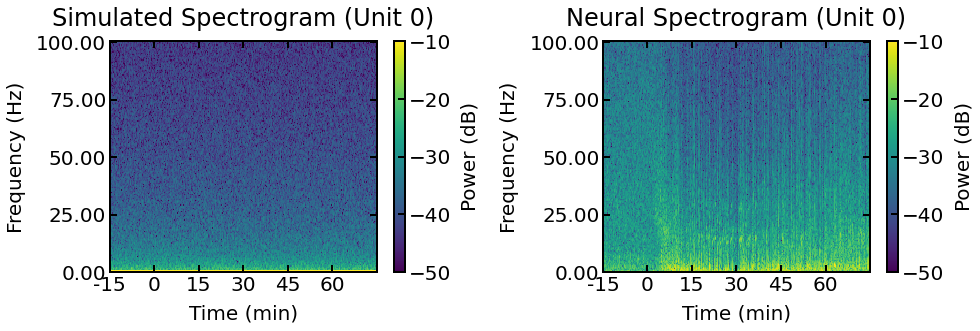

In [210]:
plt.figure(figsize=(14, 5))

spec_limit = 100
spec_limit_ind = np.argmax(f > spec_limit)

plt.subplot(1, 2, 1)
plt.pcolormesh(simulated_spec[f <= spec_limit])
plt.colorbar(label='Power (dB)')
plt.clim([-50, -10])
ax = plt.gca()
plt.xticks(np.arange(0, 900*5 + 1, 900), np.arange(-15, 61, 15))
# plt.xticks(np.arange(0, 900*5 + 1, 900), np.arange(-15, 61, 15))
yticks = ax.get_yticks()
plt.yticks([i for i in yticks if i < spec_limit_ind], [f"{f[int(i)]:.2f}" for i in yticks if i < spec_limit_ind])
# plt.ylim([0, 30])
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')
plt.title(f"Simulated Spectrogram (Unit {i})")

plt.subplot(1, 2, 2)
plt.pcolormesh(real_spec[f <= spec_limit])
plt.colorbar(label='Power (dB)')
plt.clim([-50, -10])
ax = plt.gca()
plt.xticks(np.arange(0, 900*5 + 1, 900), np.arange(-15, 61, 15))
yticks = ax.get_yticks()
plt.yticks([i for i in yticks if i < spec_limit_ind], [f"{f[int(i)]:.2f}" for i in yticks if i < spec_limit_ind])
# plt.ylim([0, 150])
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')
plt.title(f"Neural Spectrogram (Unit {i})")
plt.tight_layout()
plt.show()

# Correlations

In [ ]:
start_time = 45 # minutes
duration = 10 # s

In [49]:
correls_sim = np.zeros((N, N))
correls_neural = np.zeros((N, N))
correls_cross = np.zeros((N, N))
start_ind = start_time*60*1000
end_ind = start_time*60*1000 + duration*1000
iterator = tqdm(total=N*N)
for i in range(N):
    for j in range(N):
        correls_sim[i, j] = scipy.stats.pearsonr(x[start_ind:end_ind, i], x[start_ind:end_ind, j])[0]
        correls_neural[i, j] = scipy.stats.pearsonr(neural_data[start_ind:end_ind, i], neural_data[start_ind:end_ind, j])[0]
        correls_cross[i, j] = scipy.stats.pearsonr(x[start_ind:end_ind, i], neural_data[start_ind:end_ind, j])[0]
        iterator.update()
iterator.close()

  0%|          | 0/2500 [00:00<?, ?it/s]

In [62]:
simulated_ordering = np.abs(correls_cross).mean(axis=1).argsort()[::-1]
neural_ordering = np.abs(correls_cross).mean(axis=0).argsort()[::-1]

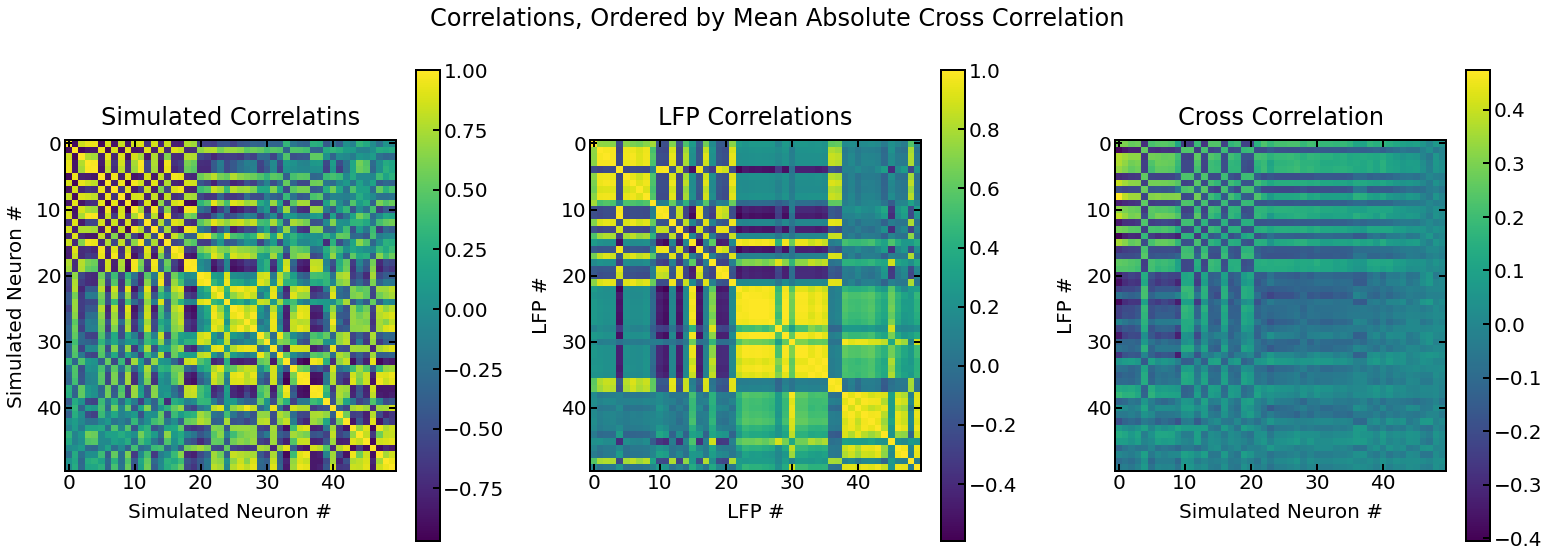

In [67]:
plt.figure(figsize=(22, 8))
plt.subplot(1, 3, 1)
plt.imshow(correls_sim[simulated_ordering, :][:, simulated_ordering])
plt.xlabel('Simulated Neuron #')
plt.ylabel('Simulated Neuron #')
plt.title('Simulated Correlatins')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(correls_neural[neural_ordering, :][:, neural_ordering])
plt.ylabel('LFP #')
plt.xlabel('LFP #')
plt.title('LFP Correlations')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(correls_cross[simulated_ordering, :][:, neural_ordering])
plt.xlabel('Simulated Neuron #')
plt.ylabel('LFP #')
plt.title('Cross Correlation')
plt.colorbar()
plt.suptitle("Correlations, Ordered by Mean Absolute Cross Correlation")
plt.tight_layout()
plt.show()

# Testing

In [ ]:
section, window, stride, p, window_ind, T_pred, directory, N, dt, results_dir = task_queue.get_nowait()

In [73]:
from utils import load_window_from_chunks
from multiproc_VAR_p_grid_search import compute_VAR_p, predict_VAR_p
from statsmodels.tsa.api import VAR

In [82]:
section = 'pre'
window = 4
stride = 5
p = 4
window_ind = 4
T_pred = 25
directory = load('/om/user/eisenaj/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01_lfp_chunked_240s/directory')

In [83]:
area = 'vlPFC'

In [84]:
bandpass_info = {'flag': False}

In [86]:
N = 253

In [89]:
%%time
start = time.time()
start_ind = window_ind*int(stride/dt)
end_ind = window_ind*int(stride/dt) + int(window/dt)
start_time = window_ind*stride
end_time = window_ind*stride + window
all_window_data = load_window_from_chunks(start_time, end_time + T_pred*dt, directory, N, dt)
if bandpass_info['flag']:
    all_window_data = butter_bandpass_filter(all_window_data, bandpass_info['low'], bandpass_info['high'], 1/dt)
test_data = all_window_data[-T_pred - p:]
window_data = all_window_data[:-T_pred]

window_name = f"window_start_{start_time}_end_{end_time}"

if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

CPU times: user 8.29 ms, sys: 339 ms, total: 347 ms
Wall time: 345 ms


In [65]:
%%time
# COMPUTE VAR(p)
results = compute_VAR_p(window_data, p, unit_indices)

CPU times: user 349 ms, sys: 18.9 ms, total: 368 ms
Wall time: 199 ms


In [69]:
%%time 
if unit_indices is None:
        chunk = window_data
else:
    chunk = window_data[:, unit_indices]

CPU times: user 2.83 ms, sys: 0 ns, total: 2.83 ms
Wall time: 2.53 ms


In [70]:
PCA_dim = -1

In [71]:
%%time
results = {}
results['explained_variance'] = None
if PCA_dim > 0:
    if PCA_dim < 2:
        raise ValueError(f"PCA dimension must be greater than 1; provided value was {PCA_dim}")
    pca = PCA(n_components=PCA_dim)
    chunk = pca.fit_transform(chunk)
    results['explained_variance'] = pca.explained_variance_ratio_

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 21.5 µs


In [74]:
%%time
model = VAR(chunk)
VAR_results = model.fit(p)

CPU times: user 224 ms, sys: 88 µs, total: 224 ms
Wall time: 128 ms


In [78]:
%%time
N = chunk.shape[1]
A_mat = np.zeros((N*p, N*p))
for i in range(p):
    A_mat[0:N][:, i*N:(i+1)*N] = VAR_results.coefs[i]

CPU times: user 568 µs, sys: 0 ns, total: 568 µs
Wall time: 391 µs


In [80]:
%%time

for i in range(p - 1):
    A_mat[(i + 1)*N:(i + 2)*N][:, i*N:(i + 1)*N] = np.eye(N)

CPU times: user 337 µs, sys: 49 µs, total: 386 µs
Wall time: 292 µs


In [81]:
%%time
e = np.linalg.eigvals(A_mat)   
results['eigs'] = e  
results['criticality_inds'] = np.abs(e)

CPU times: user 133 ms, sys: 4.11 ms, total: 137 ms
Wall time: 68.6 ms


In [66]:
%%time

# PREDICT
train_prediction, train_true_vals = predict_VAR_p(window_data, results['coefs'], results['intercept'], unit_indices)
train_mse = ((train_prediction - train_true_vals)**2).mean()
test_prediction, test_true_vals = predict_VAR_p(test_data, results['coefs'], results['intercept'], unit_indices)
test_mse = ((test_prediction - test_true_vals)**2).mean()
persistence_baseline = ((all_window_data[-T_pred:] - all_window_data[-T_pred - 1:-1])**2).mean()

CPU times: user 22 ms, sys: 12 µs, total: 22 ms
Wall time: 13.6 ms


In [67]:
%%time
# ADD TO DICTIONARY
results['train_mse'] = train_mse
results['test_mse'] = test_mse
results['persistence_baseline'] = persistence_baseline

# ADD TIMESTAMPS
results['start_ind'] = start_ind
results['end_ind'] = end_ind
results['start_time'] = start_time
results['end_time'] = end_time

# ADD PARAMETERS
results['window'] = window
results['stride'] = stride
results['p'] = p
results['T_pred'] = T_pred
results['area'] = area
results['section'] = section

# save(results, uniquify(os.path.join(results_dir, area, window_name)))

end = time.time()
print(f'elapsed: {end - start}')

elapsed: 25.297553539276123
CPU times: user 795 µs, sys: 0 ns, total: 795 µs
Wall time: 654 µs


In [63]:
0.247*422805/60/60

29.00912083333333